# Geocode our collected addresses

This version makes different analyses, but doesn't try for the time dimension. `folium` is broken in that regard.

In [1]:
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
from matplotlib.patches import Rectangle
from folium.plugins import HeatMap, HeatMapWithTime

## Read in the list of accidents

In [2]:
filename = "geocoded/full_combined_geocodes.csv"

dffull = pd.read_csv(filename)
dffull['count'] = 1 # For the heatmap
print(f"We have {len(dffull)} accidents to map.")

We have 8917 accidents to map.


### Clean up data

In [3]:
try:
    ## Depending on the version of our data, we may have an unnamed first column
    dffull.rename(columns={'Unnamed: 0':'ts'}, inplace=True)
    print("Renamed timestamp column to `ts`.")
except:
    pass

Renamed timestamp column to `ts`.


In [4]:
try:
    filter1 = dffull['Lat'].str.contains('not defined')
    filter2 = dffull['Long'].str.contains('not defined')
    df = dffull[~filter1 & ~filter2].copy()
except:
    df = dffull.copy()
    pass

In [5]:
filter1 = df['Lat'].notna()
filter2 = df['Long'].notna()

df = df.loc[(filter1 & filter2)]

In [6]:
print(f"We have {len(df)} accidents to map.")

We have 8917 accidents to map.


## Add time index

In [7]:
df['ts'] = pd.to_datetime(df['date'])
df['timestamp'] = df['ts']

In [8]:
df.set_index('ts', inplace=True)

## Define the `generateBaseMap()` function

In [9]:
oxford_latlong = [34.36257113484134, -89.5091504751761]

In [10]:
# Possible tilesets ["Stamen Terrain", "Stamen Toner", "Mapbox Bright"]
def generateBaseMap(default_location=oxford_latlong, default_zoom_start=12, tiles='Stamen Terrain'):
    base_map = folium.Map(
        location=default_location
        ,control_scale=True
        ,zoom_start=default_zoom_start
    )
    return base_map

### Make a test map, using our default town latlong

This just makes a map but doesn't plot anything.

In [11]:
testmap = generateBaseMap()
display(testmap)

## Full heat map

In [13]:
mapv1 = generateBaseMap()

points = list(
                zip(df.Lat.values.astype(float), 
                    df.Long.values.astype(float)
                   )
            )
hmap = HeatMap( points,
                min_opacity=0.5,
                max_val=200,
                radius=10, blur=10, 
                max_zoom=1, 
               )

hmap.add_to(mapv1)
display(mapv1)

mapv1.save('html/index-0500-heatmap-v1.html')

## Accidents by year

The earliest and the latest years will have incomplete data.

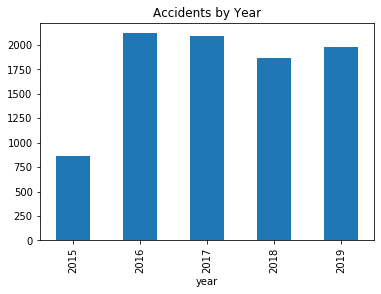

In [14]:
df['year'] = df['timestamp'].dt.year


plt.figure(figsize = (6,4))
ax = df.groupby('year').size().plot.bar(title='Accidents by Year')
plt.show()

### Maps by year

In [15]:
for y in range(2015, 2019):
    dfyear = df.query(f"year=={y}").copy()

    m = generateBaseMap()

    points = list(
                    zip(dfyear.Lat.values.astype(float), 
                        dfyear.Long.values.astype(float)
                       )
                )
    hmap = HeatMap( points,
                    min_opacity=0.5,
                    max_val=200,
                    radius=10, blur=10, 
                    max_zoom=1, 
                   )


    hmap.add_to(m)
    display(m)

/opt/anaconda3/envs/tensor2/lib/python3.6/site-packages/pandas/core/generic.py:456: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
/opt/anaconda3/envs/tensor2/lib/python3.6/site-packages/pandas/core/generic.py:464: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


## Accidents by weekday

In [16]:
df["weekday"] = pd.to_datetime(df.date).dt.dayofweek
dfweekday = df.groupby('weekday').size()
dfweekday.index = ["Mon", "Tues", "Wed", "Thu", "Fri", "Sat", "Sun"]

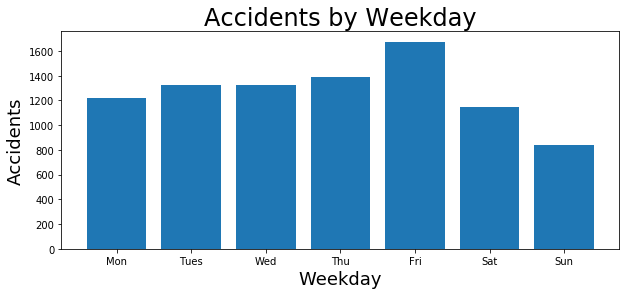

In [32]:
plt.figure(figsize = (10,4))
plt.bar(dfweekday.index, dfweekday)

plt.xlabel('Weekday',fontsize=18)
plt.ylabel('Accidents',fontsize=18)
plt.title("Accidents by Weekday",fontsize=24)

plt.show()

## Accidents by time of day

/opt/anaconda3/envs/tensor2/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


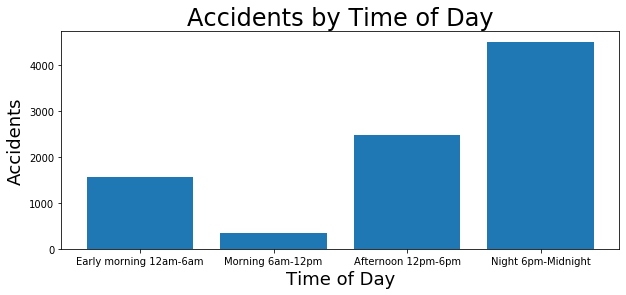

In [18]:
df['timeofday'] = np.nan

filter = df.index.isin(df.between_time('06:00', '12:00', include_start=True, include_end=False).index)
df['timeofday'].loc[filter] = 'Morning 6am-12pm'

filter = df.index.isin(df.between_time('12:00', '18:00', include_start=True, include_end=False).index)
df['timeofday'].loc[filter] = 'Afternoon 12pm-6pm'

filter = df.index.isin(df.between_time('18:00', '23:59', include_start=True, include_end=False).index)
df['timeofday'].loc[filter] = 'Night 6pm-Midnight'

filter = df.index.isin(df.between_time('00:00', '06:00', include_start=True, include_end=False).index)
df['timeofday'].loc[filter] = 'Early morning 12am-6am'

dftmp = df.groupby('timeofday').size()

dftmp = dftmp.reindex(index = ['Early morning 12am-6am', 'Morning 6am-12pm', 'Afternoon 12pm-6pm', 'Night 6pm-Midnight']).copy()

plt.figure(figsize = (10,4))
plt.bar(dftmp.index, dftmp)


plt.xlabel('Time of Day',fontsize=18)
plt.ylabel('Accidents',fontsize=18)
plt.title("Accidents by Time of Day",fontsize=24)

plt.show()

## Seasonality of accidents

In [19]:
import seaborn as sns

In [20]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['dayofyear'] = df['timestamp'].dt.dayofyear

Pivot table aggregating count of accidents by year/month

In [21]:
pt = df.pivot_table(index="year",columns="month",values="Lat", aggfunc="count")
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
pt.columns = months

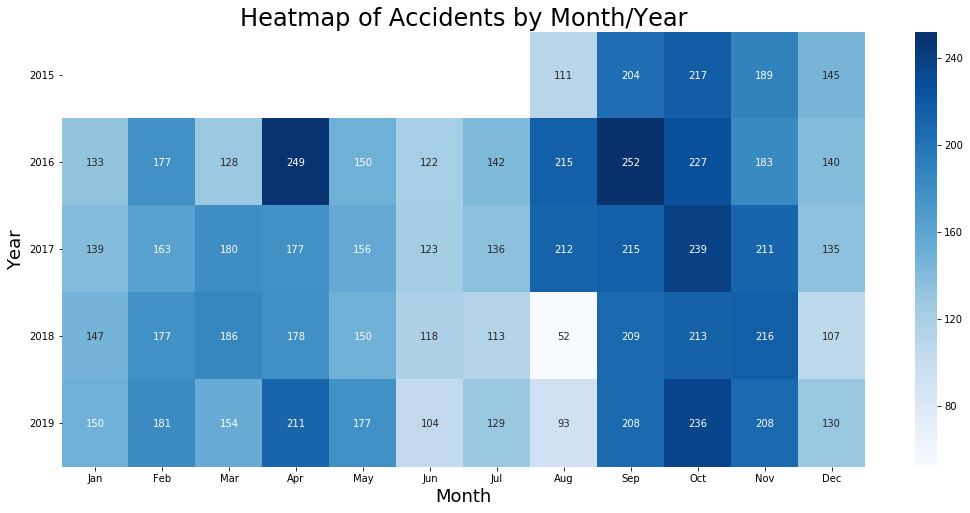

In [22]:
plt.figure(figsize = (18,8))

sns.heatmap(pt, annot=True, fmt='.0f', cmap='Blues') #Reds YlGnBu

# Yikes, center Y-axis tick labels
pos, textvals = plt.yticks()
plt.yticks(pos, textvals, rotation=0, fontsize="10", va="center")

# FIX Matplotlib regression bug https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t) # update the ylim(bottom, top) values


plt.xlabel('Month',fontsize=18)
plt.ylabel('Year',fontsize=18)
plt.title("Heatmap of Accidents by Month/Year",fontsize=24)
plt.show()

### Heatmap for when university is in session

Semesters span partials of months, so for this version, highlight only full months when university is in session.

We used the [2019 Ole Miss academic calendar](https://registrar.olemiss.edu/academic-calendar/) for all years, since it doesn't change dramatically from year to year.

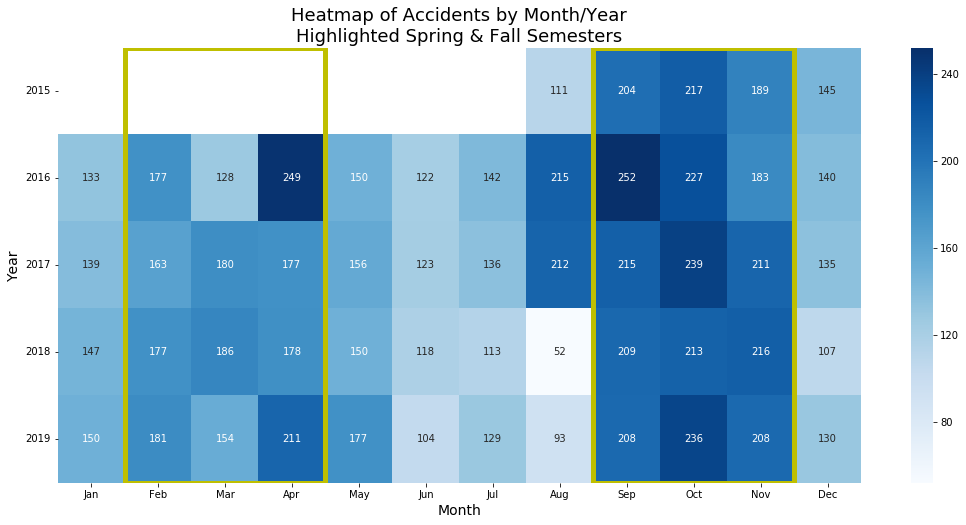

In [23]:
plt.figure(figsize = (18,8))

ax = sns.heatmap(pt, annot=True, fmt='.0f', cmap='Blues') #Reds YlGnBu

# Yikes, center Y-axis tick labels
pos, textvals = plt.yticks()
plt.yticks(pos,textvals, rotation=0, fontsize="10", va="center")

# FIX Matplotlib regression bug https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t) # update the ylim(bottom, top) values


## Highlight complete months, manually entering values:
from matplotlib.patches import Rectangle
ax.add_patch(Rectangle((8, 0), 3, 5, fill=False, edgecolor='y', lw=5))
ax.add_patch(Rectangle((1, 0), 3, 5, fill=False, edgecolor='y', lw=5))

plt.xlabel('Month',fontsize=14)
plt.ylabel('Year',fontsize=14)
plt.title("Heatmap of Accidents by Month/Year\nHighlighted Spring & Fall Semesters",fontsize=18)
plt.show()


## By date version

In [24]:
pt = df.pivot_table(index="year",columns="dayofyear",values="Lat", aggfunc="count")

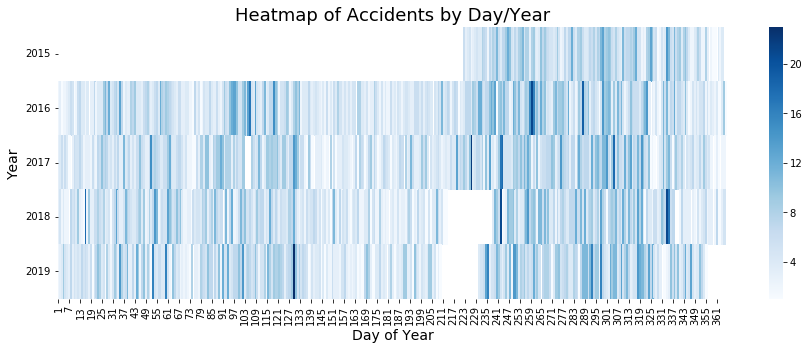

In [33]:
plt.figure(figsize = (15,5))

sns.heatmap(pt, annot=False, fmt='.0f', cmap='Blues') #Reds YlGnBu

# Yikes, center Y-axis tick labels
pos, textvals = plt.yticks()
plt.yticks(pos, textvals, rotation=0, fontsize="10", va="center")

# FIX Matplotlib regression bug https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t) # update the ylim(bottom, top) values


plt.xlabel('Day of Year',fontsize=14)
plt.ylabel('Year',fontsize=14)
plt.title("Heatmap of Accidents by Day/Year",fontsize=18)
plt.show()

### Now with highlights for school in session

In [26]:
# Spring 2019 starts Jan 22 ends May 10
print("Spring 2019 starts day of year:", date(2019, 1, 22).timetuple().tm_yday)
print("Spring 2019 ends   day of year:", date(2019, 5, 10).timetuple().tm_yday)

# Fall 2019 starts Aug 26 ends Dec 13
print("Fall 2019 starts day of year:", date(2019, 8, 26).timetuple().tm_yday)
print("Fall 2019 ends   day of year:", date(2019, 12, 13).timetuple().tm_yday)

Spring 2019 starts day of year: 22
Spring 2019 ends   day of year: 130
Fall 2019 starts day of year: 238
Fall 2019 ends   day of year: 347


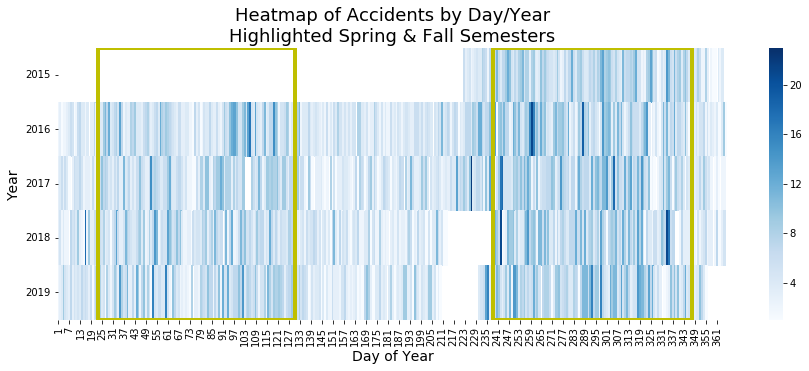

In [34]:
plt.figure(figsize = (15,5))

ax = sns.heatmap(pt, annot=False, fmt='.0f', cmap='Blues') #Reds YlGnBu

# Yikes, center Y-axis tick labels
pos, textvals = plt.yticks()
plt.yticks(pos, textvals, rotation=0, fontsize="10", va="center")

# FIX Matplotlib regression bug https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t) # update the ylim(bottom, top) values


## Highlight complete months of semester, manually entering values:
ax.add_patch(Rectangle((22, 0), 108, 5, fill=False, edgecolor='y', lw=4))
ax.add_patch(Rectangle((238, 0), 109, 5, fill=False, edgecolor='y', lw=4))


plt.xlabel('Day of Year',fontsize=14)
plt.ylabel('Year',fontsize=14)
plt.title("Heatmap of Accidents by Day/Year\nHighlighted Spring & Fall Semesters",fontsize=18)
plt.show()

### Now with highlights for home game gamedays

Schedules grabbed from https://fbschedules.com/ncaa-2018/team/ole-miss. Break out LSU gamedays.

In [28]:
homegames = [
     date(2019, 9, 7)
    ,date(2019, 9, 14)
    ,date(2019, 9, 21)
    ,date(2019, 10, 5)
    ,date(2019, 10, 19)
    ,date(2019, 11, 9)
    ,date(2019, 11, 16)
    ,date(2018, 9, 8)
    ,date(2018, 9, 15)
    ,date(2018, 9, 22)
    ,date(2018, 10, 6)
    ,date(2018, 10, 20)
    ,date(2018, 11, 3)
    ,date(2018, 11, 22)
    ,date(2017, 9, 2)
    ,date(2017, 9, 9)
    ,date(2017, 10, 14)
    ,date(2017, 10, 21)
    ,date(2017, 10, 28)
    ,date(2017, 11, 11)
    ,date(2017, 11, 18)
    ,date(2016, 9, 10)
    ,date(2016, 9, 17)
    ,date(2016, 9, 24)
    ,date(2016, 10, 1)
    ,date(2016, 10, 29)
    ,date(2016, 11, 5)
    ,date(2016, 11, 26)
    ,date(2015, 9, 5)
    ,date(2015, 9, 12)
    ,date(2015, 9, 26)
    ,date(2015, 10, 10)
    ,date(2015, 10, 24)
    ,date(2015, 11, 7)
    ,date(2015, 11, 21)
]

In [29]:
lsu_homegamedays = [
     date(2015, 11, 21)
    ,date(2017, 10, 21)
    ,date(2019, 11, 16)
]

In [30]:
pt_football_season = pt.iloc[0:5, 230:]

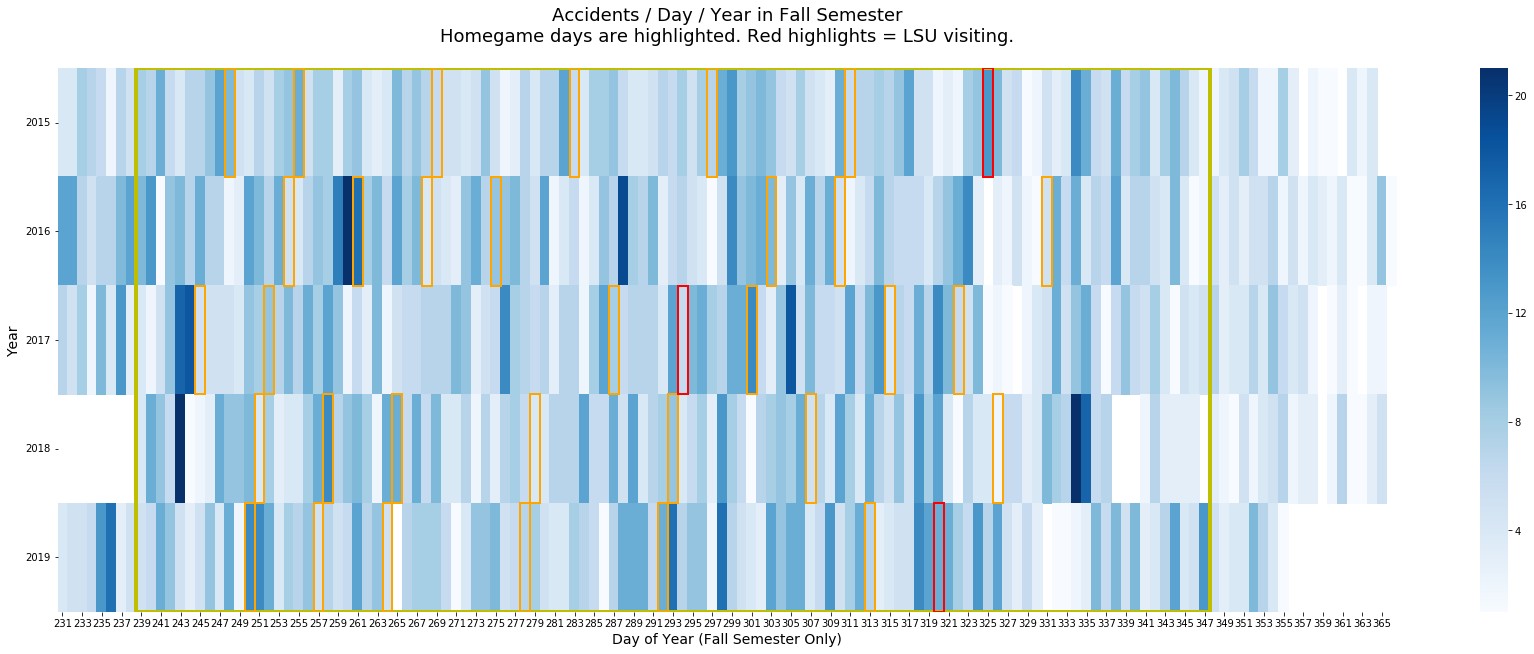

In [35]:
plt.figure(figsize = (30,10))


ax = sns.heatmap(pt_football_season, annot=False, fmt='.0f', cmap='Blues') #Reds YlGnBu

# Yikes, center Y-axis tick labels
pos, textvals = plt.yticks()
plt.yticks(pos, textvals, rotation=0, fontsize="10", va="center")

# FIX Matplotlib regression bug https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t) # update the ylim(bottom, top) values



## Fall semester
ax.add_patch(Rectangle((238 - 230, 0), 109, 5, fill=False, edgecolor='y', lw=4))

## Homegames
for h in homegames:
    dy = h.timetuple().tm_yday
    yr = h.year

    idx_row = 4 - (2019-yr)
    idx_col = dy - 1 - 230
    
    ax.add_patch(Rectangle((idx_col, idx_row), 1, 1, fill=False, edgecolor='orange', lw=2))

for h in lsu_homegamedays:
    dy = h.timetuple().tm_yday
    yr = h.year

    idx_row = 4 - (2019-yr)
    idx_col = dy - 1 - 230
    
    ax.add_patch(Rectangle((idx_col, idx_row), 1, 1, fill=False, edgecolor='r', lw=2))

title="""Accidents / Day / Year in Fall Semester
Homegame days are highlighted. Red highlights = LSU visiting.
"""
plt.xlabel('Day of Year (Fall Semester Only)',fontsize=14)
plt.ylabel('Year',fontsize=14)
plt.title(title, horizontalalignment='center',fontsize=18)

plt.show()